<a href="https://colab.research.google.com/github/atrokhym/finbot/blob/main/Crypto_Feature_Importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crypto Trading Feature Importance Analysis for Deep Reinforcement Learning

Notebook based on:

0: Lopez de Prado, M. (2018). Advances in financial machine learning. John Wiley & Sons.

https://www.amazon.com/Advances-Financial-Machine-Learning-Marcos/dp/1119482089

1: AI4Finance Foundation

https://github.com/AI4Finance-Foundation

2: Optimal Trading Rules Detection with Triple Barrier Labeling

https://www.youtube.com/watch?v=U2CxilKFue4

3: Data Labelling, the Triple-barrier Method

https://towardsdatascience.com/the-triple-barrier-method-251268419dcd


4: Financial Machine Learning Part 1: Labels

https://towardsdatascience.com/financial-machine-learning-part-1-labels-7eeed050f32e#:~:text=Adding%20Path%20Dependency%3A%20Triple%2DBarrier,%3A%20the%20triple%2Dbarrier%20method.


5: Meta-Labeling: Solving for Non Stationarity and Position Sizing

https://www.youtube.com/watch?v=WbgglcXfEzA


6: Advances in Financial Machine Learning

https://github.com/JackBrady/Financial-Machine-Learning/blob/master/USDJPY_Notebook.ipynb


Specifically, important features for currently one coin at the time only

In [50]:
# Install required packages

%cd /
!pip install wrds
!pip install swig
!git clone https://github.com/AI4Finance-Foundation/FinRL-Meta
%cd FinRL-Meta/
!pip install git+https://github.com/AI4Finance-Foundation/ElegantRL.git
!pip install -q condacolab
import condacolab
condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
!pip install gputil
!pip install trading_calendars
!pip install python-binance


/
fatal: destination path 'FinRL-Meta' already exists and is not an empty directory.
/FinRL-Meta
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-req-build-k9x5pw2i
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-req-build-k9x5pw2i
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 5e828af1503098f4da046c0f12432dbd4ef8bd97
  Preparing metadata (setup.py) ... done
✨🍰✨ Everything looks OK!
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-394duds7
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-394duds7
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit

In [51]:
!sed -i 's/binance.com/binance.us/g' /FinRL-Meta/meta/data_processors/binance.py

In [52]:
#install TA-lib (technical analysis)
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar xvzf ta-lib-0.4.0-src.tar.gz
import os
os.chdir('ta-lib')
!./configure --prefix=/usr
!make
!make install
os.chdir('../')
!cd
!pip install TA-Lib
#!pip install ta-lib
!conda install -y -c conda-forge ta-lib

--2025-03-19 17:40:53--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 104.18.13.149, 104.18.12.149, 2606:4700::6812:d95, ...
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|104.18.13.149|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2025-03-19 17:40:53--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:d95, ...
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://zenlayer.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2025-03-19 17:40:53--  http://zenlayer.dl.sour

In [53]:
# Other imports

import scipy as sp
import math
import pandas as pd
import requests
import json
import matplotlib.dates as mdates
import numpy as np
import pickle
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from meta.data_processor import DataProcessor

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns

from datetime import datetime, timedelta
from talib.abstract import MACD, RSI, CCI, DX
from binance.client import Client
from pandas.testing import assert_frame_equal
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from IPython.display import display, HTML

#from google.colab import files

In [54]:
# Plot settings

SCALE_FACTOR = 2

#plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [5 * SCALE_FACTOR, 2 * SCALE_FACTOR]
plt.rcParams['figure.dpi'] = 300 * SCALE_FACTOR
plt.rcParams['font.size'] = 5 * SCALE_FACTOR
plt.rcParams['axes.labelsize'] = 5 * SCALE_FACTOR
plt.rcParams['axes.titlesize'] = 6 * SCALE_FACTOR
plt.rcParams['xtick.labelsize'] = 4 * SCALE_FACTOR
plt.rcParams['ytick.labelsize'] = 4 * SCALE_FACTOR
plt.rcParams['font.family'] = 'serif'

# Part 1: Adapted Binance downloader


Any features you think of are probably coming out of OHLCV data or alternative data streams. The functions required to obtain the new features are added here and added to the eventual dataframe.

## 1.1 Set contants and use BinanceProcessor


In [55]:
# Set constants:

ticker_list = ['ETHUSDT']


TIME_INTERVAL = '1h'

TRAIN_START_DATE = '2015-01-01'
TRAIN_END_DATE= '2019-08-01'
TRADE_START_DATE = '2019-08-01'
TRADE_END_DATE = '2020-01-03'


technical_indicator_list = ['macd',
                             'macd_signal',
                             'macd_hist',
                             'rsi',
                             'cci',
                             'dx'
                             ]

if_vix = False

In [56]:
# Process data using unified data processor
p = DataProcessor(data_source='binance', start_date=TRAIN_START_DATE, end_date=TRADE_END_DATE, time_interval=TIME_INTERVAL)
p.download_data(ticker_list=ticker_list)
p.clean_data()
df = p.dataframe

binance successfully connected
Download complete! Dataset saved to ./data/dataset.csv. 
Shape of DataFrame: (2428, 8)


In [57]:
df.head()

,tic,time,open,high,low,close,adjusted_close,volume
0,ETHUSDT,2019-09-23 08:00:00,209.55,209.55,209.55,209.55,209.55,0.01
1,ETHUSDT,2019-09-23 13:00:00,209.55,209.55,209.55,209.55,209.55,0.00
2,ETHUSDT,2019-09-23 14:00:00,209.55,209.55,209.55,209.55,209.55,0.00
3,ETHUSDT,2019-09-23 15:00:00,209.55,209.55,209.55,209.55,209.55,0.00
4,ETHUSDT,2019-09-23 16:00:00,209.55,209.55,209.55,209.55,209.55,0.00


## 1.2 Add technical indicators


In [58]:
def add_technical_indicator(df, tech_indicator_list):
    # print('Adding self-defined technical indicators is NOT supported yet.')
    # print('Use default: MACD, RSI, CCI, DX.')

    final_df = pd.DataFrame()
    for i in df.tic.unique():
        tic_df = df[df.tic == i].copy()
        tic_df['rsi'] = RSI(tic_df['close'], timeperiod=14)
        tic_df['macd'], tic_df['macd_signal'], tic_df['macd_hist'] = MACD(tic_df['close'], fastperiod=12,
                                                                          slowperiod=26, signalperiod=9)
        tic_df['cci'] = CCI(tic_df['high'], tic_df['low'], tic_df['close'], timeperiod=14)
        tic_df['dx'] = DX(tic_df['high'], tic_df['low'], tic_df['close'], timeperiod=14)
        final_df = final_df._append(tic_df)
    return final_df

In [59]:
processed_df=add_technical_indicator(df,technical_indicator_list)
processed_df.tail()

,tic,time,open,high,low,close,adjusted_close,volume,rsi,macd,macd_signal,macd_hist,cci,dx
423,ETHUSDT,2020-01-02 19:00:00,127.50,127.61,127.19,127.61,127.61,2.40100,34.752250,-0.779471,-0.561215,-0.218256,-121.696072,43.683906
424,ETHUSDT,2020-01-02 20:00:00,127.61,127.61,127.61,127.61,127.61,0.00000,34.752250,-0.797713,-0.608515,-0.189199,-88.803658,43.683906
425,ETHUSDT,2020-01-02 21:00:00,127.45,127.73,127.45,127.73,127.73,4.52344,36.173873,-0.793342,-0.645480,-0.147862,-72.848681,45.438725
426,ETHUSDT,2020-01-02 22:00:00,127.35,127.48,127.35,127.48,127.48,4.35506,34.487980,-0.800820,-0.676548,-0.124272,-73.780296,46.559541
427,ETHUSDT,2020-01-02 23:00:00,127.22,127.22,127.22,127.22,127.22,0.32834,32.777084,-0.818293,-0.704897,-0.113396,-77.441077,48.053486


In [60]:
def add_technical_indicator(df, tech_indicator_list):
    # print('Adding self-defined technical indicators is NOT supported yet.')
    # print('Use default: MACD, RSI, CCI, DX.')

    final_df = pd.DataFrame()
    for i in df.tic.unique():
        tic_df = df[df.tic == i].copy()
        tic_df['rsi'] = RSI(tic_df['close'], timeperiod=14)
        tic_df['macd'], tic_df['macd_signal'], tic_df['macd_hist'] = MACD(tic_df['close'], fastperiod=12,
                                                                          slowperiod=26, signalperiod=9)
        tic_df['cci'] = CCI(tic_df['high'], tic_df['low'], tic_df['close'], timeperiod=14)
        tic_df['dx'] = DX(tic_df['high'], tic_df['low'], tic_df['close'], timeperiod=14)
        final_df = final_df.append(tic_df)
    return final_df

In [61]:
def add_technical_indicator(df, tech_indicator_list):
    # print('Adding self-defined technical indicators is NOT supported yet.')
    # print('Use default: MACD, RSI, CCI, DX.')

    final_df = pd.DataFrame()
    for i in df.tic.unique():
        tic_df = df[df.tic == i].copy()
        tic_df['rsi'] = RSI(tic_df['close'], timeperiod=14)
        tic_df['macd'], tic_df['macd_signal'], tic_df['macd_hist'] = MACD(tic_df['close'], fastperiod=12,
                                                                          slowperiod=26, signalperiod=9)
        tic_df['cci'] = CCI(tic_df['high'], tic_df['low'], tic_df['close'], timeperiod=14)
        tic_df['dx'] = DX(tic_df['high'], tic_df['low'], tic_df['close'], timeperiod=14)
        final_df = final_df.append(tic_df)
    return final_df

In [62]:
def add_technical_indicator(df, tech_indicator_list):
    # print('Adding self-defined technical indicators is NOT supported yet.')
    # print('Use default: MACD, RSI, CCI, DX.')

    final_df = pd.DataFrame()
    for i in df.tic.unique():
        tic_df = df[df.tic == i].copy()
        tic_df['rsi'] = RSI(tic_df['close'], timeperiod=14)
        tic_df['macd'], tic_df['macd_signal'], tic_df['macd_hist'] = MACD(tic_df['close'], fastperiod=12,
                                                                          slowperiod=26, signalperiod=9)
        tic_df['cci'] = CCI(tic_df['high'], tic_df['low'], tic_df['close'], timeperiod=14)
        tic_df['dx'] = DX(tic_df['high'], tic_df['low'], tic_df['close'], timeperiod=14)
        final_df = final_df.append(tic_df)
    return final_df

In [63]:
# Drop unecessary columns and make time as index
processed_df.index=pd.to_datetime(processed_df.time)
processed_df.drop('time', inplace=True, axis=1)
print(processed_df.tail(20))

                         tic    open    high     low   close  adjusted_close  \
time                                                                           
2020-01-02 04:00:00  ETHUSDT  129.11  129.59  129.11  129.59          129.59   
2020-01-02 05:00:00  ETHUSDT  129.55  129.55  129.55  129.55          129.55   
2020-01-02 06:00:00  ETHUSDT  129.24  129.39  129.24  129.39          129.39   
2020-01-02 07:00:00  ETHUSDT  129.12  129.12  129.03  129.03          129.03   
2020-01-02 08:00:00  ETHUSDT  129.68  130.18  129.68  130.18          130.18   
2020-01-02 09:00:00  ETHUSDT  129.78  129.78  129.78  129.78          129.78   
2020-01-02 10:00:00  ETHUSDT  130.11  130.13  130.00  130.00          130.00   
2020-01-02 11:00:00  ETHUSDT  130.00  130.00  130.00  130.00          130.00   
2020-01-02 12:00:00  ETHUSDT  129.91  129.91  129.68  129.68          129.68   
2020-01-02 13:00:00  ETHUSDT  129.14  129.25  129.10  129.10          129.10   
2020-01-02 14:00:00  ETHUSDT  129.10  12

# Part 2: Triple barrier method/Data Labeling
Introduction here:

https://www.youtube.com/watch?v=U2CxilKFue4

## 2.1 Add volatility


In [64]:
def get_vol(prices, span=100):
    # 1. compute returns of the form p[t]/p[t-1] - 1
    df0 = prices.pct_change()
    # 2. estimate rolling standard deviation
    df0 = df0.ewm(span=span).std()
    return df0

In [65]:
data_ohlcv = processed_df.assign(volatility=get_vol(processed_df.close)).dropna()

In [66]:
data_ohlcv.head(10)

,tic,open,high,low,close,adjusted_close,volume,rsi,macd,macd_signal,macd_hist,cci,dx,volatility
time,,,,,,,,,,,,,,
2019-09-24 21:00:00,ETHUSDT,164.04,169.70,162.59,167.51,167.51,129.96333,9.991658,-10.785442,-5.573561,-5.211881,-114.911010,87.268875,0.027329
2019-09-24 22:00:00,ETHUSDT,167.54,169.57,167.19,168.95,168.95,34.44680,13.724926,-11.120824,-6.683014,-4.437811,-86.935693,87.268875,0.026964
2019-09-24 23:00:00,ETHUSDT,170.67,170.67,167.09,167.09,167.09,3.46653,12.976255,-11.405231,-7.627457,-3.777774,-73.595975,82.166647,0.026428
2019-09-25 00:00:00,ETHUSDT,166.84,168.90,166.82,168.90,168.90,2.69290,17.681977,-11.353695,-8.372705,-2.980990,-63.248528,82.294163,0.026145
2019-09-25 01:00:00,ETHUSDT,169.11,172.79,169.08,172.79,172.79,9.26086,26.838428,-10.873618,-8.872887,-2.000730,-40.069826,64.089418,0.026272
2019-09-25 02:00:00,ETHUSDT,174.15,174.15,172.17,172.17,172.17,5.73958,26.335619,-10.423032,-9.182916,-1.240115,-24.822917,58.143259,0.025772
2019-09-25 03:00:00,ETHUSDT,171.31,171.85,169.75,169.75,169.75,3.52000,24.413075,-10.144276,-9.375188,-0.769088,-33.732033,60.861110,0.025341
2019-09-25 04:00:00,ETHUSDT,169.20,169.20,167.93,167.93,167.93,5.36373,23.050223,-9.955458,-9.491242,-0.464216,-45.326462,62.816576,0.024891
2019-09-25 05:00:00,ETHUSDT,167.87,168.77,167.87,168.77,168.77,3.36449,25.127717,-9.627063,-9.518406,-0.108657,-38.819942,62.882415,0.024526


## 2.2 Adding Path Dependency: Triple-Barrier Method

To better incorporate the stop-loss and take-profit scenarios of a hypothetical trading strategy, we will modify the fixed-horizon labeling method so that it reflects which barrier has been touched first — upper, lower, or horizon. Hence the name: the triple-barrier method.

The labeling schema is defined as follows:

* y = 2 : top barrier is hit first
* y = 1 : right barrier is hit first
* y = 0 : bottom barrier is hit first

What about the side of the bet?

The schema above works fine for long-only strategies, however things get more complicated when we allow for both long and short bets. If we are betting short, our profit/loss is inverted relative to the price action — we profit if the price goes down and we lose when the price goes up.

In order to account for this, we can simply represent side as 2 for long and 0 for short. Thus we can multiply our returns by the side, so whenever we’re betting short the negative returns become positive and vice-versa. Effectively, we flip the y = 2 and y = 0 labels if side = 0.

Let’s take a shot at the implementation (based on MLDP’s code).
First, we define the procedure for getting the timestamps of the horizon barriers:

### Create function to obtain the barrier hits

In [67]:
def get_barriers():
  #create a container
  barriers = pd.DataFrame(columns=['days_passed',
            'price', 'vert_barrier', \
            'top_barrier', 'bottom_barrier'], \
              index = daily_volatility.index)
  for day, vol in daily_volatility.items():
    days_passed = len(daily_volatility.loc \
                  [daily_volatility.index[0] : day])
    #set the vertical barrier
    if (days_passed + t_final < len(daily_volatility.index) \
        and t_final != 0):
        vert_barrier = daily_volatility.index[
                            days_passed + t_final]
    else:
        vert_barrier = np.nan
    #set the top barrier
    if upper_lower_multipliers[0] > 0:
        top_barrier = prices.loc[day] + prices.loc[day] * \
                      upper_lower_multipliers[0] * vol
    else:
        #set it to NaNs
        top_barrier = pd.Series(index=prices.index)
    #set the bottom barrier
    if upper_lower_multipliers[1] > 0:
        bottom_barrier = prices.loc[day] - prices.loc[day] * \
                      upper_lower_multipliers[1] * vol
    else:
        #set it to NaNs
        bottom_barrier = pd.Series(index=prices.index)

    barriers.loc[day, ['days_passed', 'price', 'vert_barrier','top_barrier', 'bottom_barrier']] = \
    days_passed, prices.loc[day], vert_barrier, top_barrier, bottom_barrier

  return barriers

In [68]:
# Set barrier parameters

daily_volatility = data_ohlcv['volatility']
t_final = 25
upper_lower_multipliers = [2, 2]
price = data_ohlcv['close']
prices = price[daily_volatility.index]

In [69]:
barriers = get_barriers()
barriers

,days_passed,price,vert_barrier,top_barrier,bottom_barrier
time,,,,,
2019-09-24 21:00:00,1,167.51,2019-09-25 23:00:00,176.665844,158.354156
2019-09-24 22:00:00,2,168.95,2019-09-26 00:00:00,178.060976,159.839024
2019-09-24 23:00:00,3,167.09,2019-09-26 01:00:00,175.921585,158.258415
2019-09-25 00:00:00,4,168.9,2019-09-26 02:00:00,177.731832,160.068168
2019-09-25 01:00:00,5,172.79,2019-09-26 03:00:00,181.86905,163.71095
...,...,...,...,...,...
2020-01-02 19:00:00,2391,127.61,NaN,128.797569,126.422431
2020-01-02 20:00:00,2392,127.61,NaN,128.785833,126.434167
2020-01-02 21:00:00,2393,127.73,NaN,128.896181,126.563819


## 2.3 Function to get label for the dataset (0, 1, 2)

* 0: hit the stoploss
* 1: hit the time out
* 2: hit the profit take

The part in this function (commented out), allows for easy conversion to a regression analysis (currently it is classification). If one changes the labels to (-1, 0, 1), and change the hit on the vertical barrier to the function stated below.

That will make hitting the profit take barrier 1, the vertical barrier a range from (-1, 1), and the stoploss barrier -1. This is a continuos space then.

```
barriers['out'][i] = max(
          [(price_final - price_initial)/
            (top_barrier - price_initial), \
            (price_final - price_initial)/ \
            (price_initial - bottom_barrier)],\
            key=abs)
```

In [70]:
def get_labels():
    """
    start: first day of the window
    end:last day of the window
    price_initial: first day stock price
    price_final:last day stock price
    top_barrier: profit taking limit
    bottom_barrier:stop loss limt
    condition_pt:top_barrier touching conditon
    condition_sl:bottom_barrier touching conditon
    """
    barriers["label_barrier"] = None
    for i in range(len(barriers.index)):
        start = barriers.index[i]
        end = barriers.vert_barrier[i]
        if pd.notna(end):
            # assign the initial and final price
            # price_initial = barriers.price[start]
            # price_final = barriers.price[end]
            # assign the top and bottom barriers
            top_val = barriers.top_barrier[i]
            bottom_val = barriers.bottom_barrier[i]
            top_barrier = top_val if np.isscalar(top_val) else (top_val.iloc[0] if not top_val.empty else np.nan)
            bottom_barrier = bottom_val if np.isscalar(bottom_val) else (bottom_val.iloc[0] if not bottom_val.empty else np.nan)

            # set the profit taking and stop loss conditons
            idx = data_ohlcv.index.slice_indexer(start, end)
            slice_close = data_ohlcv['close'].iloc[idx]
            condition_pt = (slice_close >= top_barrier).any()
            condition_sl = (slice_close <= bottom_barrier).any()

            # assign the labels
            if condition_pt:
                barriers["label_barrier"][i] = 2
            elif condition_sl:
                barriers["label_barrier"][i] = 0
            else:
                # Change to regression analysis by switching labels (-1, 0, 1)
                # and uncommenting the alternative function for vert barrier
                barriers["label_barrier"][i] = 1
                # barriers['label_barrier'][i] = max(
                #           [(price_final - price_initial)/
                #             (top_barrier - price_initial), \
                #             (price_final - price_initial)/ \
                #             (price_initial - bottom_barrier)],\
                #             key=abs)
    return



In [71]:
# Use function to produce barriers

get_labels()
barriers

# Merge the barriers with the main dataset and drop the last t_final + 1 barriers (as they are too close to the end)

data_ohlcv = data_ohlcv.merge(barriers[['vert_barrier', 'top_barrier', 'bottom_barrier', 'label_barrier']], left_on='time', right_on='time')
data_ohlcv.drop(data_ohlcv.tail(t_final + 1).index,inplace = True)
data_ohlcv.head(5)

Streaming output truncated to the last 5000 lines.
<ipython-input-70-d363f0fbc1d7>:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  top_val = barriers.top_barrier[i]
<ipython-input-70-d363f0fbc1d7>:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bottom_val = barriers.bottom_barrier[i]
<ipython-input-70-d363f0fbc1d7>:40: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  barriers["label_barrier"][i] = 1
<ipython-input-70-d363f0fbc

,tic,open,high,low,close,adjusted_close,volume,rsi,macd,macd_signal,macd_hist,cci,dx,volatility,vert_barrier,top_barrier,bottom_barrier,label_barrier
time,,,,,,,,,,,,,,,,,,
2019-09-24 21:00:00,ETHUSDT,164.04,169.70,162.59,167.51,167.51,129.96333,9.991658,-10.785442,-5.573561,-5.211881,-114.911010,87.268875,0.027329,2019-09-25 23:00:00,176.665844,158.354156,1
2019-09-24 22:00:00,ETHUSDT,167.54,169.57,167.19,168.95,168.95,34.44680,13.724926,-11.120824,-6.683014,-4.437811,-86.935693,87.268875,0.026964,2019-09-26 00:00:00,178.060976,159.839024,1
2019-09-24 23:00:00,ETHUSDT,170.67,170.67,167.09,167.09,167.09,3.46653,12.976255,-11.405231,-7.627457,-3.777774,-73.595975,82.166647,0.026428,2019-09-26 01:00:00,175.921585,158.258415,1
2019-09-25 00:00:00,ETHUSDT,166.84,168.90,166.82,168.90,168.90,2.69290,17.681977,-11.353695,-8.372705,-2.980990,-63.248528,82.294163,0.026145,2019-09-26 02:00:00,177.731832,160.068168,1
2019-09-25 01:00:00,ETHUSDT,169.11,172.79,169.08,172.79,172.79,9.26086,26.838428,-10.873618,-8.872887,-2.000730,-40.069826,64.089418,0.026272,2019-09-26 03:00:00,181.86905,163.71095,1


In [72]:
# Count barrier hits ( 0 = stoploss, 1 = timeout, 2 = profit take)
pd.Series(data_ohlcv['label_barrier']).value_counts()

,count
label_barrier,
2,1100
0,1006
1,263


<ipython-input-73-932811931a8e>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  end = data_ohlcv.vert_barrier[TIMESTAMP_TO_PLOT]
<ipython-input-73-932811931a8e>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  upper_barrier = data_ohlcv.top_barrier[TIMESTAMP_TO_PLOT]
<ipython-input-73-932811931a8e>:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lower_barrier = data_ohlcv.bottom_barrier[TIMESTAMP_TO_PLOT]


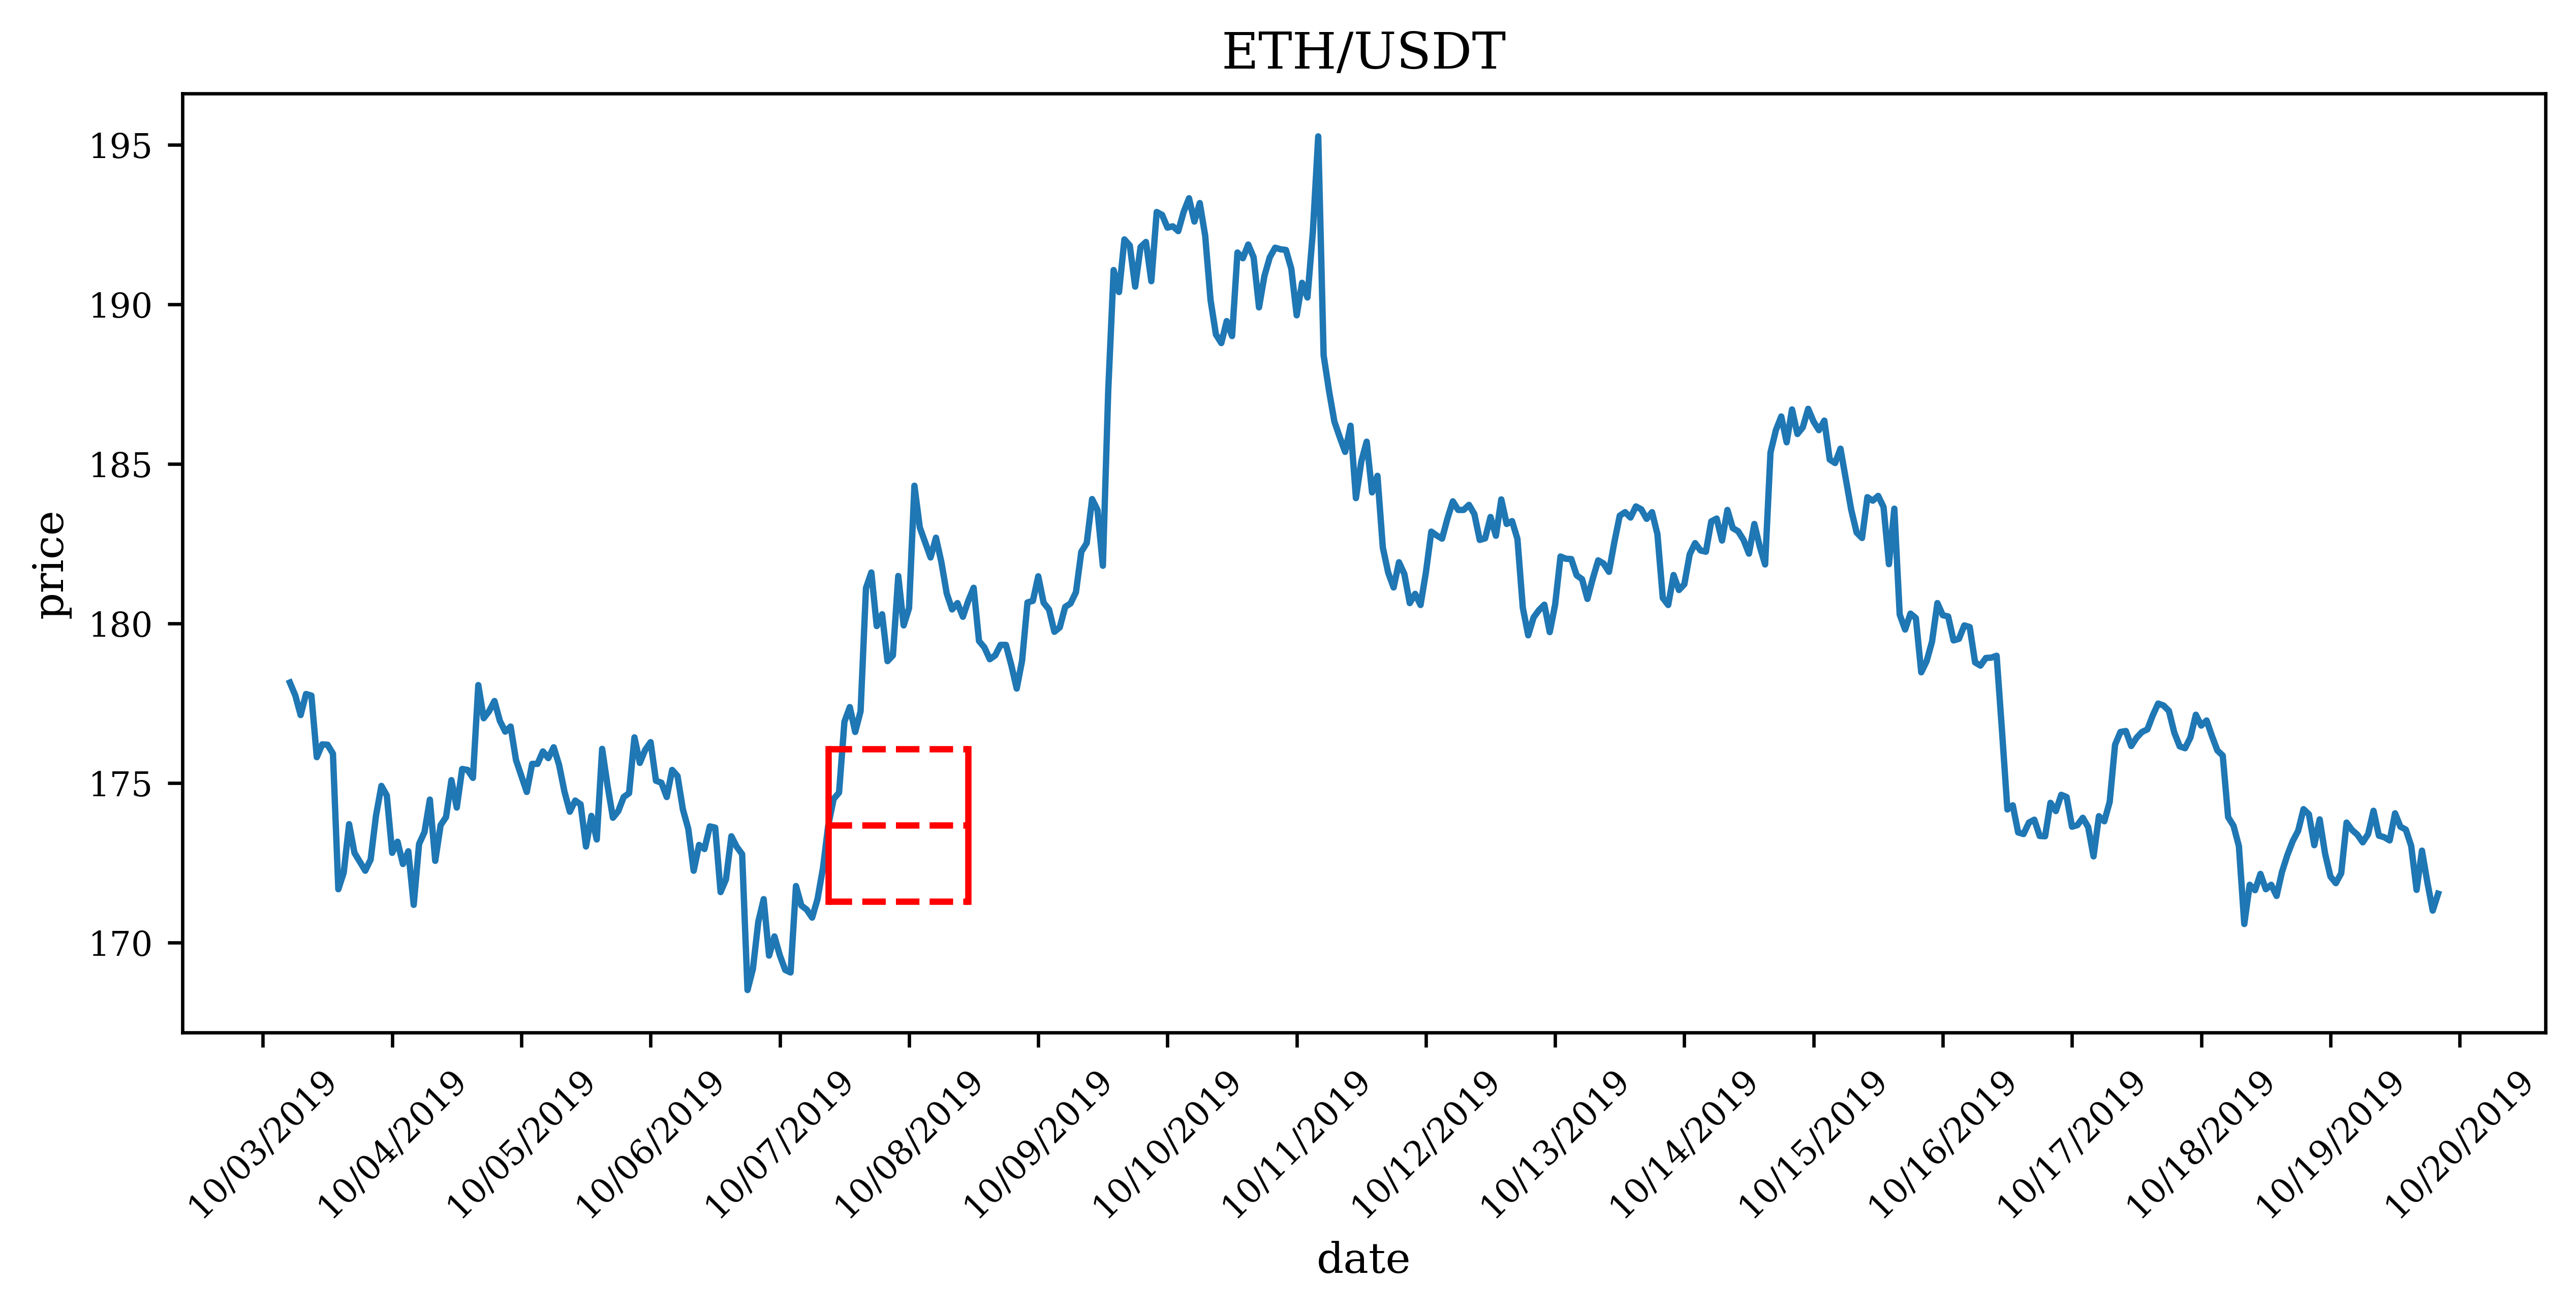

In [73]:
fig,ax = plt.subplots()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))


TIMESTAMP_TO_PLOT= 300

ax.set(title='ETH/USDT',
       xlabel='date', ylabel='price')
ax.plot(data_ohlcv.close[200:600])

start = data_ohlcv.index[TIMESTAMP_TO_PLOT]
end = data_ohlcv.vert_barrier[TIMESTAMP_TO_PLOT]
upper_barrier = data_ohlcv.top_barrier[TIMESTAMP_TO_PLOT]
lower_barrier = data_ohlcv.bottom_barrier[TIMESTAMP_TO_PLOT]

ax.plot([start, end], [upper_barrier, upper_barrier], 'r--');
ax.plot([start, end], [lower_barrier, lower_barrier], 'r--');
ax.plot([start, end], [(lower_barrier + upper_barrier)*0.5, \
                       (lower_barrier + upper_barrier)*0.5], 'r--');
ax.plot([start, start], [lower_barrier, upper_barrier], 'r-');
ax.plot([end, end], [lower_barrier, upper_barrier], 'r-');

# Part 3: Copying the Neural Network present in ElegantRL ActorPPO agent.

In ElegantRL from AI4Finance, all the preprogrammed Agents are present:

https://github.com/AI4Finance-Foundation/ElegantRL/blob/master/elegantrl/agents/net.py

Some of the actions output discrete actions (classification), and some continuous actions (regression). This notebook can be adapted for both. by turning the labeling method in a (-1, 0, 1) and changing the Neural network to output a continuous space between -1 and 1.

Therefore this notebook allows for analysis for both regression and classification.




In [74]:
data_ohlcv = data_ohlcv.drop(['vert_barrier', 'top_barrier', 'bottom_barrier','adjusted_close','tic'], axis = 1)

In [75]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.state_dim = 12       # all the features
        self.mid_dim = 2**10      # net dimension
        self.action_dim = 3       # output (sell/nothing/buy)

        # make a copy of the model in ActorPPO (activation function in forward function)

        # Original initial layers
        self.fc1 = nn.Linear(self.state_dim, self.mid_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(self.mid_dim, self.mid_dim)

        # Original residual layers
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(self.mid_dim, self.mid_dim)
        self.hw1 = nn.Hardswish()
        self.fc_out = nn.Linear(self.mid_dim, self.action_dim)

    def forward(self, x):
        x = x.float()

        # Original initial layers
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)

        # Original residual layers
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.hw1(x)
        x = self.fc_out(x)
        return x

model_NN1 = Net()
print(model_NN1)

Net(
  (fc1): Linear(in_features=12, out_features=1024, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (hw1): Hardswish()
  (fc_out): Linear(in_features=1024, out_features=3, bias=True)
)


In [76]:
class ClassifierDataset(Dataset):

    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__ (self):
        return len(self.X_data)

## 3.1 Set constants and train/test split

In [77]:
# Set constants
batch_size=16
epochs=300

# Reinitiating data here
data = data_ohlcv

X = data[['open', 'high', 'low', 'close', 'volume', 'rsi', 'macd', 'macd_signal', 'macd_hist', 'cci', 'dx', 'volatility']].values
y = np.squeeze(data[['label_barrier']].values).astype(int)

# Split into train+val and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Normalize input
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# initialize sets and convet them to Pytorch dataloader sets
train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.astype(int)).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.astype(int)).long())


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size
                          )

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=1)

## 3.2 Check if GPU availabble

In [78]:
# Check GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Set optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_NN1.parameters(), lr=0.0001)

cuda:0


In [79]:
## Make sure you are working on GPU
assert torch.cuda.is_available(), "Change your runtime to GPU! Currently working on CPU... zzzzz"

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Mar 19 17:41:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P0             30W /   70W |     218MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 3.3 Now train the ```model_NN1```; as long as the test loss reduces keep on training!

In [80]:
# Train function
def train(fold, model, device, trainloader, optimizer, epoch):
  model.train()
  correct_train = 0
  correct_this_batch_train = 0
  total_train_loss = 0
  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data)
      train_loss = criterion(output, target.flatten())
      train_loss.backward()
      optimizer.step()

      if batch_idx % 100 == 0:
          print('Train Fold/Epoch: {}/{} [{}/{} ({:.0f}%)]\ttrain_loss: {:.6f}'.format(
              fold,epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), train_loss.item()))

      # Measure accuracy on train set
      total_train_loss += train_loss.item()
      _, y_pred_tags_train = torch.max(output, dim = 1)
      correct_this_batch_train = y_pred_tags_train.eq(target.flatten().view_as(y_pred_tags_train))
      correct_train += correct_this_batch_train.sum().item()

  return correct_train, train_loss

In [81]:
# Test function
def test(fold,model, device, test_loader, correct_train, train_loss):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          test_loss += criterion(output, target.flatten()).item()  # sum up batch loss

          # Measure accuracy on test set
          _, y_pred_tags = torch.max(output, dim = 1)
          correct_this_batch = y_pred_tags.eq(target.flatten().view_as(y_pred_tags))
          correct += correct_this_batch.sum().item()

  test_loss /= len(test_loader.dataset)
  train_loss /= len(train_loader.dataset)

  # Print train accuracy for epoch
  # TODO: still a bug in summed up batch train loss
  print('\nTrain set for fold {}: Average train_loss: {:.4f}, Accuracy: {}/{} ({:.5f}%)'.format(
  fold, train_loss, correct_train, len(train_loader.dataset),
  100 * correct_train / len(train_loader.dataset)))

  # Print test result for epoch
  print('Test set for fold {}:  Average test_loss:  {:.4f}, Accuracy: {}/{} ({:.5f}%)\n'.format(
      fold, test_loss, correct, len(test_loader.dataset),
      100 * correct / len(test_loader.dataset)))

In [82]:
model_NN1.to(device)

# State fold (no PurgedKFold build yet, ignore this)
# took about 1hour to train when epochs=300

epochs=100
fold = 0
for epoch in range(1, epochs + 1):
  correct_train, train_loss = train(fold, model_NN1, device, train_loader, optimizer, epoch)
  test(fold, model_NN1, device, test_loader, correct_train, train_loss)

Train Fold/Epoch: 0/1 [0/1895 (0%)]	train_loss: 1.104755
Train Fold/Epoch: 0/1 [1600/1895 (84%)]	train_loss: 0.933412

Train set for fold 0: Average train_loss: 0.0004, Accuracy: 876/1895 (46.22691%)
Test set for fold 0:  Average test_loss:  0.9573, Accuracy: 220/474 (46.41350%)

Train Fold/Epoch: 0/2 [0/1895 (0%)]	train_loss: 0.910460
Train Fold/Epoch: 0/2 [1600/1895 (84%)]	train_loss: 0.937155

Train set for fold 0: Average train_loss: 0.0004, Accuracy: 890/1895 (46.96570%)
Test set for fold 0:  Average test_loss:  0.9524, Accuracy: 225/474 (47.46835%)

Train Fold/Epoch: 0/3 [0/1895 (0%)]	train_loss: 0.870137
Train Fold/Epoch: 0/3 [1600/1895 (84%)]	train_loss: 0.930636

Train set for fold 0: Average train_loss: 0.0004, Accuracy: 907/1895 (47.86280%)
Test set for fold 0:  Average test_loss:  0.9488, Accuracy: 231/474 (48.73418%)

Train Fold/Epoch: 0/4 [0/1895 (0%)]	train_loss: 0.835933
Train Fold/Epoch: 0/4 [1600/1895 (84%)]	train_loss: 0.919182

Train set for fold 0: Average train_lo

In [83]:
# Save model to disk and save in your own files to save you some time

from google.colab import files

filename = 'model_NN1'
out = open(filename, 'wb')

with open(filename + '.pkl', 'wb') as fid:
  pickle.dump(model_NN1, fid)

# load pickle file
with open(filename + '.pkl', 'rb') as fid:
     model_NN1 = pickle.load(fid)

files.download(filename + '.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [84]:
# load pickle filetorch.from_numpy(y_test.astype(int)).long()

filename = 'model_NN1'
with open(filename + '.pkl', 'rb') as fid:
     model_NN1_pickle = pickle.load(fid)
model_NN1

Net(
  (fc1): Linear(in_features=12, out_features=1024, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (hw1): Hardswish()
  (fc_out): Linear(in_features=1024, out_features=3, bias=True)
)

## 3.4 Get classification report

In [85]:
with torch.no_grad():
  # Show accuracy on test set
  model_NN1.eval()

  # predict proba
  y_pred_nn1_proba = model_NN1(torch.from_numpy(X_test).float().to(device))
  y_pred_nn1 = torch.argmax(y_pred_nn1_proba, dim=1)
  y_pred_nn1 = y_pred_nn1.cpu().detach().numpy()

# print predction values
print('labels in prediction:', np.unique(y_pred_nn1), '\n')

# print report
label_names = ['long', 'no bet', 'short']
print(classification_report(y_test.astype(int), y_pred_nn1, target_names=label_names))

labels in prediction: [0 1 2] 

              precision    recall  f1-score   support

        long       0.67      0.73      0.70       201
      no bet       0.86      0.45      0.59        53
       short       0.71      0.74      0.72       220

    accuracy                           0.70       474
   macro avg       0.75      0.64      0.67       474
weighted avg       0.71      0.70      0.70       474



In [86]:
np.bincount(y_pred_nn1)

array([217,  28, 229])

# Part 4: Feature Importance Analysis

After we have a working neural network model (up to 66% accuracy with this network size), we can do a pertubation of the columns and do a prediction. When a column is pertubated and it delivers the highest error, that means that column in most important for the prediction of the action.

## Pertubation Rank (PR)

In [87]:
def perturbation_rank(model,x,y,names):
    errors = []

    X_saved = x
    y = y.flatten()

    with torch.no_grad():
        model.eval()
        for i in range(x.shape[1]):

            # Convert to numpy, shuffle, convert back to tensor, predict
            x = x.detach().numpy()
            np.random.shuffle(x[:,i])
            x = torch.from_numpy(x).float().to(device)
            pred = model(x)

            # log_loss requires (classification target, probabilities)
            pred = pred.cpu().detach().numpy()
            error = metrics.log_loss(y, pred)
            errors.append(error)

            # Reset x to saved tensor matrix
            x = X_saved

    max_error = np.max(errors)
    importance = [e/max_error for e in errors]

    data = {'name':names,'error':errors,'importance':importance}
    result = pd.DataFrame(data,columns = ['name','error','importance'])
    result.sort_values(by=['importance'],ascending=[0],inplace=True)
    result.reset_index(inplace=True,drop=True)
    return result

In [88]:
model_NN1

Net(
  (fc1): Linear(in_features=12, out_features=1024, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (hw1): Hardswish()
  (fc_out): Linear(in_features=1024, out_features=3, bias=True)
)

In [89]:
names = list(data_ohlcv.columns)
names.remove('label_barrier')
rank = perturbation_rank(model_NN1,
                         torch.from_numpy(X_test).float(),
                         torch.from_numpy(y_test.astype(int)).long(),
                         names
                         )

display(rank)

/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:3001: UserWarning: T

,name,error,importance
0,volatility,6.001312,1.000000
1,dx,5.855554,0.975712
2,cci,5.679221,0.946330
3,macd_hist,5.461070,0.909979
4,macd_signal,5.387168,0.897665
5,rsi,5.361859,0.893448
6,macd,5.333356,0.888698
7,volume,4.969167,0.828014
8,close,4.561192,0.760033
9,low,4.343428,0.723746


In [90]:
names = list(data_ohlcv.columns)
names.remove('label_barrier')
rank = perturbation_rank(model_NN1,
                         torch.from_numpy(X_test).float(),
                         torch.from_numpy(y_test.astype(int)).long(),
                         names
                         )

display(rank)

/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:3001: UserWarning: T

,name,error,importance
0,macd_hist,5.994380,1.000000
1,macd_signal,5.903498,0.984839
2,dx,5.828022,0.972248
3,cci,5.816981,0.970406
4,macd,5.774789,0.963367
5,volatility,5.767524,0.962155
6,rsi,5.604034,0.934881
7,volume,5.320325,0.887552
8,close,5.304436,0.884901
9,low,4.673965,0.779725
